In [1]:
import numpy as np
import pandas as pd
from numba import njit, prange
from interpolation import interp
from scipy.optimize import minimize

In [2]:
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
γ = 0.5772156649

In [4]:
# region (10) * lag_investment (2) * lag2_investent(2) * ordered_violator (3) * disc_violations (20)

n_naics_recode = 7
n_region = 10
n_Linv = 2
n_L2inv = 2
n_ordered_violator = 3
n_DAV = 20
n_vio = 2

# focus on the fist sector
sector = 0

In [5]:
f = open("/Users/hyde/Dropbox/UArizona/ECON 696/data_for_bellman_computations.csv")
lines = f.readlines()

simulated_dist = np.empty((n_naics_recode, n_region, n_Linv, n_L2inv, n_ordered_violator, n_DAV, 80, 7))

for line in lines[1:]:
    line = line.split(',')
    for i in range(80):
        simulated_dist[int(line[0])-1, int(line[1])-1, int(line[2]), int(line[3]), int(line[4]), int(line[5])-1][i] = [float(e) for e in line[7+7*i:14+7*i]]

In [6]:
f = open("/Users/hyde/Dropbox/UArizona/ECON 696/analysis_data.csv")
lines = f.readlines()

for i, col in enumerate(lines[0].split(',')):
    print(col, i, i-2)

lines[0]
data = []
for line in lines[1:]:
    line = [e for e in line.strip().split(',')[2:18]]
    vio = int(line[2])
    Linv = int(line[4])
    inv = int(line[6])
    naics_recode = int(line[7])
    region = int(line[9])
    ordered_violator = int(line[13])
    DAV = float(line[15])
    
    if (naics_recode - 1) == sector:
        data.append([region-1, Linv, ordered_violator, DAV, vio, inv])
        
data = np.array(data)

frsnumber 0 -2
quarter 1 -1
inspection 2 0
fine 3 1
violation 4 2
HPV_recorded 5 3
lag_investment 6 4
lag2_investment 7 5
investment 8 6
naics_recode 9 7
orig_naics 10 8
region 11 9
compliance 12 10
violator 13 11
HPV_status 14 12
ordered_violator 15 13
numHPV 16 14
disc_uncleared_violations 17 15
violator_notHPV 18 16
lag_compliance 19 17
lag_violator_notHPV 20 18
lag_HPV_status 21 19
invest_times_sum_next_six
 22 20


In [21]:
def BGL():
    
    # depreciation rate
    δ = 0.1
    
    # discount factor
    β = 0.95 ** (1/4.)
    
    # initialize V(Ω') and V(Ω)
    # set the initial values to be 0
    
    # the range of DAV for interpolation
    DAV_range = np.arange(0., 10.0, 0.5)
    
    @njit
    def initialize():
        # V(Ω')
        # Notice that L2inv is a useless state for Ω'
        VΩ_prime = np.zeros((n_region, n_Linv, n_ordered_violator, n_DAV, n_vio))
        # V(Ω) 
        VΩ = np.zeros((n_region, n_Linv, n_L2inv, n_ordered_violator, n_DAV))
        
        return VΩ_prime, VΩ
    
    @njit(parallel=True)
    def VΩ_prime_operator(VΩ_prime, VΩ, θ):
        
        θ_I, θ_F, θ_V, θ_H, θ_X = θ
        
        for region in prange(n_region):
            for Linv in prange(n_Linv):
                for ordered_violator in prange(n_ordered_violator):
                    for i_DAV in prange(n_DAV):
                        for vio in prange(n_vio):
                            DAV = i_DAV * 0.5

                            # for compliance
                            if ordered_violator == 0:
                                VΩ_prime[region, Linv, ordered_violator, i_DAV, vio] = β * VΩ[region, 0, Linv, ordered_violator, i_DAV] + γ

                            else:

                                DAV_next = min((1 - δ) * DAV + vio, 9.5)

                                VΩ_prime[region, Linv, ordered_violator, i_DAV, vio] = \
                                    np.log(np.exp(β * interp(DAV_range, VΩ[region, 0, Linv, ordered_violator, :], DAV_next))
                                    + np.exp(θ_X + β * interp(DAV_range, VΩ[region, 1, Linv, ordered_violator, :], DAV_next))) + γ



    @njit(parallel=True)
    def VΩ_operator(VΩ_prime, VΩ, θ):
        
        θ_I, θ_F, θ_V, θ_H, θ_X = θ
        
        for region in prange(n_region):
            for Linv in prange(n_Linv):
                for L2inv in prange(n_L2inv):
                    for ordered_violator in prange(n_ordered_violator):
                        for i_DAV in prange(n_DAV):
                            
                            # find out the transitions
                            # for compliance
                            if (ordered_violator == 0):
                                transition = simulated_dist[sector, region, 0, 0, 0, 0]
                            else:
                                transition = simulated_dist[sector, region, Linv, L2inv, ordered_violator, i_DAV]
                            
                            VΩ[region, Linv, L2inv, ordered_violator, i_DAV] = 0.
                            
                            for i in prange(80):
                                ins, vio, fine, prob, prob0, prob1, prob2 = transition[i]
                                util = θ_I * ins + fine * θ_F + vio * θ_V
                                
                                # if transit to compliance plant
                                util += prob0 * VΩ_prime[region, Linv, 0, 0, int(vio)]
                                
                                # if transit to regular violator or high priority violator
                                util += prob1 * VΩ_prime[region, Linv, 1, i_DAV, int(vio)]
                                util += prob2 * (VΩ_prime[region, Linv, 2, i_DAV, int(vio)] + θ_H)
                                
                                VΩ[region, Linv, L2inv, ordered_violator, i_DAV] += prob * util
    
    def solve_bellman(θ, tol=1e-7, verbose=True):

        VΩ_prime, VΩ = initialize()

        dist = np.inf
        i = 0

        while dist > tol:

            VΩ_old = np.copy(VΩ)

            VΩ_operator(VΩ_prime, VΩ, θ)
            VΩ_prime_operator(VΩ_prime, VΩ, θ)

            dist = np.max(np.abs(VΩ_old - VΩ))
            i += 1

            if (i % 100 == 0) & (verbose):
                print(f'{i} times of iteration: error = {dist}')

        return VΩ_prime, VΩ
    
    @njit
    def solve_bellman_jitted(θ, tol=1e-7):

        VΩ_prime, VΩ = initialize()

        dist = np.inf

        while dist > tol:

            VΩ_old = np.copy(VΩ)

            VΩ_operator(VΩ_prime, VΩ, θ)
            VΩ_prime_operator(VΩ_prime, VΩ, θ)

            dist = np.max(np.abs(VΩ_old - VΩ))

        return VΩ_prime, VΩ

    @njit(parallel=True)
    def comute_CCP_inv(VΩ_prime, VΩ, θ):

        CCP_inv = np.zeros_like(VΩ_prime)

        θ_I, θ_F, θ_V, θ_H, θ_X = θ

        for region in prange(n_region):
            for Linv in prange(n_Linv):
                for ordered_violator in prange(n_ordered_violator):
                    for i_DAV in prange(n_DAV):
                        for vio in prange(n_vio):
                            DAV = i_DAV * 0.5

                            # for compliance
                            # no investment
                            if ordered_violator == 0:
                                continue

                            else:

                                DAV_next = min((1 - δ) * DAV + vio, 9.5)

                                exp_value_inv = np.exp(β * interp(DAV_range, VΩ[region, 0, Linv, ordered_violator, :], DAV_next))
                                exp_value_noinv = np.exp(θ_X + β * interp(DAV_range, VΩ[region, 1, Linv, ordered_violator, :], DAV_next))
                                CCP_inv[region, Linv, ordered_violator, i_DAV, vio] = exp_value_inv / (exp_value_inv + exp_value_noinv)

        return CCP_inv
    
    @njit
    def quasilikelihood(CCP_inv, data):
        
        L = 0.
        for i in range(data.shape[0]):
            region, Linv, ordered_violator, DAV, vio, inv = data[i]
            CCP = interp(DAV_range, CCP_inv[int(region), int(Linv), int(ordered_violator), :, int(vio)], DAV)
            
            if inv == 1:
                L += np.log(CCP)
            else:
                L += np.log(1 - CCP)
                
        return L
    
    @njit
    def quasilikelihood_wrapped(θ, data):
        
        VΩ_prime, VΩ = solve_bellman_jitted(θ)
        CCP_inv = comute_CCP_inv(VΩ_prime, VΩ, θ)
        L = quasilikelihood(CCP_inv, data)
        
        # return -L because we want to use sp.optimize.minimize to do optimization
        
        return - L
    
    @njit(parallel=True)
    def standard_error(θ, data, h):
        """
        use standard outer product approximation method.
        """
        
        L_right = np.empty((len(θ), data.shape[0]))
        L_left = np.empty((len(θ), data.shape[0]))
        L_gradient = np.empty((len(θ), data.shape[0]))
        θ_right = np.empty(len(θ))
        θ_left = np.empty(len(θ))
        
        for i in prange(len(θ)):
            θ_right[:] = θ[:]
            θ_left[:] = θ[:]
            
            θ_right[i] = θ[i] + h[i]
            VΩ_prime_right, VΩ_right = solve_bellman_jitted(θ_right)
            CCP_inv_right = comute_CCP_inv(VΩ_prime_right, VΩ_right, θ_right)
            
            θ_left[i] = θ[i] - h[i]
            VΩ_prime_left, VΩ_left = solve_bellman_jitted(θ_left)
            CCP_inv_left = comute_CCP_inv(VΩ_prime_left, VΩ_left, θ_left)
            
#             for j in range(data.shape[0]):
            for j in range(2):
                region, Linv, ordered_violator, DAV, vio, inv = data[i]
                L_right[i, j] = interp(DAV_range, CCP_inv_right[int(region), int(Linv), int(ordered_violator), :, int(vio)], DAV)
                L_left[i, j] = interp(DAV_range, CCP_inv_left[int(region), int(Linv), int(ordered_violator), :, int(vio)], DAV)
                
            L_gradient[i] = (L_right[i] - L_left[i]) / (2 * h[i])
            
        return np.linalg.inv(np.dot(L_gradient, L_gradient.T))

    return initialize, VΩ_prime_operator, VΩ_operator, solve_bellman, comute_CCP_inv, quasilikelihood, quasilikelihood_wrapped, standard_error

Compute the plant's dynamic optimization decision for the parameters $\widehat{\theta} \equiv ( \theta^X = -2, \theta^I = -0.5, \theta^V = -0.5, \theta^F = -0.1, \theta^H = -0.1 )$. Report the investment probability for all states with DAV = 2 (for which the integer grid takes on a value of 4).

In [23]:
initialize, VΩ_prime_operator, VΩ_operator, solve_bellman, comute_CCP_inv, quasilikelihood, quasilikelihood_wrapped, standard_error = BGL()

In [9]:
θ = (-2., -0.5, -0.5, -0.1, -0.1)
VΩ_prime, VΩ = solve_bellman(θ)

100 times of iteration: error = 0.47838337613728754
200 times of iteration: error = 0.041636793388242666
300 times of iteration: error = 0.011549487763218735
400 times of iteration: error = 0.003203769379631183
500 times of iteration: error = 0.0008887093822238512
600 times of iteration: error = 0.00024652347670439667
700 times of iteration: error = 6.838436265610426e-05
800 times of iteration: error = 1.8969475640062683e-05
900 times of iteration: error = 5.26203660911051e-06
1000 times of iteration: error = 1.4596623785223528e-06
1100 times of iteration: error = 4.049029982411412e-07
1200 times of iteration: error = 1.123181263551487e-07


In [10]:
%timeit solve_bellman(θ, verbose=False)

2.49 s ± 356 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
CCP_inv = comute_CCP_inv(VΩ_prime, VΩ, θ)

In [12]:
i_DAV = 4 # DAV = 2

for region in range(n_region):
    for Linv in range(n_Linv):
        for ordered_violator in range(1, 3):
            for vio in range(2):
                print(f'region={region}, Linv={Linv}, ordered_violator={ordered_violator}, vio={vio}: \
                    Pr(inv=1) = {CCP_inv[region, Linv, ordered_violator, i_DAV, vio]}')

region=0, Linv=0, ordered_violator=1, vio=0:                     Pr(inv=1) = 0.6803070493342397
region=0, Linv=0, ordered_violator=1, vio=1:                     Pr(inv=1) = 0.5373679755655467
region=0, Linv=0, ordered_violator=2, vio=0:                     Pr(inv=1) = 0.15963241589196886
region=0, Linv=0, ordered_violator=2, vio=1:                     Pr(inv=1) = 0.08510747557334229
region=0, Linv=1, ordered_violator=1, vio=0:                     Pr(inv=1) = 0.6862549739182929
region=0, Linv=1, ordered_violator=1, vio=1:                     Pr(inv=1) = 0.5020803549638929
region=0, Linv=1, ordered_violator=2, vio=0:                     Pr(inv=1) = 0.20136512697959194
region=0, Linv=1, ordered_violator=2, vio=1:                     Pr(inv=1) = 0.14579354196793798
region=1, Linv=0, ordered_violator=1, vio=0:                     Pr(inv=1) = 0.6497889422068087
region=1, Linv=0, ordered_violator=1, vio=1:                     Pr(inv=1) = 0.4868902390401721
region=1, Linv=0, ordered_violator=2

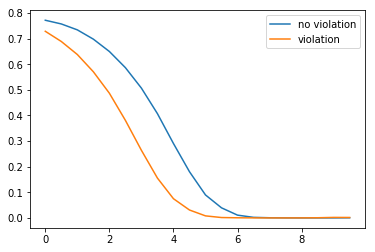

In [13]:
plt.plot(np.arange(0., 10., 0.5), CCP_inv[1, 0, 1, :, 0], label="no violation")
plt.plot(np.arange(0., 10., 0.5), CCP_inv[1, 0, 1, :, 1], label="violation")

plt.legend()

In [16]:
θ = (-2.948, -0.018, -0.303, -0.114, -0.049)
res = minimize(quasilikelihood_wrapped, θ, args=(data,), method='nelder-mead', options={'xtol': 1e-7, 'disp': True})

Optimization terminated successfully.
         Current function value: 17861.819885
         Iterations: 494
         Function evaluations: 908


In [ ]:
standard_error(res.x, data, res.x * np.sqrt(np.finfo(float).eps))

In [17]:
res.x

array([-5.78295791, -0.3756005 , -9.46118409, -2.43120456,  1.75568675])